[![colab-logo](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/japan-medical-ai/medical-ai-course-materials/blob/master/notebooks/Sequential_Data_Analysis_with_Deep_Learning.ipynb)

# 実践編: ディープラーニングを使ったモニタリングデータの時系列解析

健康意識の高まりや運動人口の増加に伴って，活動量計などのウェアラブルデバイスが普及し始めています．センサーデバイスから心拍数などの情報を取得することで，リアルタイムに健康状態をモニタリングできる可能性があることから，近年ではヘルスケア領域での活用事例も増えてきています．2018年2月には，Cardiogram社とカリフォルニア大学が共同研究の成果を発表し，心拍数データに対してDeep Learningを適用することで，高精度に糖尿病予備群を予測可能であることを報告し，大きな注目を集めました．また，Apple Watch Series 4には心電図作成の機能が搭載されるなど，センサーデバイスも進歩を続け，より精緻な情報が取得できるようになってきています．こうした背景において，モニタリングデータを収集・解析し，健康管理に繋げていく取り組みは今後益々盛んになっていくものと考えられます．


本章では，心電図の信号波形データを対象として，不整脈を検出する問題に取り組みます．

## 環境構築

本章では, 下記のライブラリを利用します.

* Cupy
* Chainer
* Scipy
* Matplotlib
* Seaborn
* Pandas
* WFDB
* Scikit-learn
* Imbalanced-learn

以下のセルを実行 (Shift + Enter) して，必要なものをインストールして下さい. 

In [0]:
!apt -y -q install tree
!pip install wfdb==2.2.1 imbalanced-learn==0.4.3

In [0]:
!curl https://colab.chainer.org/install | sh -

インストールが完了したら以下のセルを実行して，各ライブラリのインポート，及びバージョン確認を行って下さい.

In [0]:
import os
import random
import numpy as np
import chainer
import scipy
import pandas as pd
import matplotlib
import seaborn as sn
import wfdb
import sklearn
import imblearn

chainer.print_runtime_info()
print("Scipy: ", scipy.__version__)
print("Pandas: ", pd.__version__)
print("Matplotlib: ", matplotlib.__version__)
print("Seaborn: ", sn.__version__)
print("WFDB: ", wfdb.__version__)
print("Scikit-learn: ", sklearn.__version__)
print("Imbalanced-learn: ", imblearn.__version__)

Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.1.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.1.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : 2307
iDeep: 2.0.0.post3
Scipy:  1.1.0
Pandas:  0.22.0
Matplotlib:  2.1.2
Seaborn:  0.7.1
WFDB:  2.2.1
Scikit-learn:  0.20.1
Imbalanced-learn:  0.4.3


また，本章の実行結果を再現可能なように，4章 (4.2.4.4) で紹介した乱数シードの固定を行います．

（以降の計算を行う上で必ず必要となる設定ではありません．）

In [0]:
def reset_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

reset_seed(42)

## 心電図(ECG)と不整脈診断について

**心電図(Electrocardiogram, ECG)**は，心筋を協調的，律動的に動かすために刺激伝導系で伝達される電気信号を体表から記録したものであり，心電図検査は不整脈や虚血性心疾患の診断において広く用いられる検査です[[文献1](https://en.wikipedia.org/wiki/Electrocardiography), [文献2](https://www.ningen-dock.jp/wp/wp-content/uploads/2013/09/d4bb55fcf01494e251d315b76738ab40.pdf)]．

標準的な心電図は，手足からとる心電図（四肢誘導）として，双極誘導（$Ⅰ$，$Ⅱ$，$Ⅲ$），及び単極誘導（$aV_R$，$aV_L$，$aV_F$）の6誘導，胸部からとる心電図（胸部誘導）として，$V_1$，$V_2$，$V_3$，$V_4$，$V_5$，$V_6$の6誘導，計12誘導から成ります．このうち，特に不整脈のスクリーニングを行う際には，$Ⅱ$誘導と$V_1$誘導に注目して診断が行われるのが一般的とされています．

心臓が正常な状態では，ECGにおいては規則的な波形が観測され，これを**正常洞調律 (Normal sinus rhythm, NSR)**といいます．

具体的には，以下の3つの主要な波形で構成されており，

1. **P波**：心房の脱分極（心房の興奮）
1. **QRS波**：心室の脱分極（心室の興奮）
1. **T波**：心室の再分極（心室興奮の収まり）

の順番で，下図のような波形が観測されます．

![正常心電図の概略図](https://github.com/japan-medical-ai/medical-ai-course-materials/raw/master/notebooks/images/monitoring/sinus_rhythm.png)

([[文献1](https://en.wikipedia.org/wiki/Electrocardiography)]より引用)

こうした規則的な波形に乱れが生じ，調律に異常があると判断された場合，不整脈などの疑いがあるため，診断が行われることになります．

## 使用するデータセット

ここでは，ECGの公開データとして有名な[MIT-BIH Arrhythmia Database (mitdb)](https://www.physionet.org/physiobank/database/mitdb/)を使用します．

47名の患者から収集した48レコードが登録されており，各レコードファイルには約30分間の2誘導($II$，$V_1$)のシグナルデータが格納されています．また，各R波のピーク位置に対してアノテーションが付与されています．(データとアノテーションの詳細については[こちら](https://www.physionet.org/physiobank/database/html/mitdbdir/intro.htm)を御覧ください．)

データベースは[PhysioNet](https://www.physionet.org/)によって管理されており，ダウンロードや読み込み用のPythonパッケージが提供されているので，今回はそちらを利用してデータを入手します．

In [0]:
dataset_root = './dataset'
download_dir = os.path.join(dataset_root, 'download')

まずはmitdbデータベースをダウンロードしましょう．
※実行時にエラーが出た場合は，再度実行して下さい．

In [0]:
wfdb.dl_database('mitdb', dl_dir=download_dir)

Created local base download directory: ./dataset/download
Finished downloading files


無事ダウンロードが完了すると， `Finished downloading files` というメッセージが表示されます．

ファイル一覧を確認してみましょう．

In [0]:
print(sorted(os.listdir(download_dir)))

['100.atr', '100.dat', '100.hea', '101.atr', '101.dat', '101.hea', '102.atr', '102.dat', '102.hea', '103.atr', '103.dat', '103.hea', '104.atr', '104.dat', '104.hea', '105.atr', '105.dat', '105.hea', '106.atr', '106.dat', '106.hea', '107.atr', '107.dat', '107.hea', '108.atr', '108.dat', '108.hea', '109.atr', '109.dat', '109.hea', '111.atr', '111.dat', '111.hea', '112.atr', '112.dat', '112.hea', '113.atr', '113.dat', '113.hea', '114.atr', '114.dat', '114.hea', '115.atr', '115.dat', '115.hea', '116.atr', '116.dat', '116.hea', '117.atr', '117.dat', '117.hea', '118.atr', '118.dat', '118.hea', '119.atr', '119.dat', '119.hea', '121.atr', '121.dat', '121.hea', '122.atr', '122.dat', '122.hea', '123.atr', '123.dat', '123.hea', '124.atr', '124.dat', '124.hea', '200.atr', '200.dat', '200.hea', '201.atr', '201.dat', '201.hea', '202.atr', '202.dat', '202.hea', '203.atr', '203.dat', '203.hea', '205.atr', '205.dat', '205.hea', '207.atr', '207.dat', '207.hea', '208.atr', '208.dat', '208.hea', '209.atr'

ファイル名の数字はレコードIDを表しています．各レコードには3種類のファイルがあり，

- `.dat` : シグナル（バイナリ形式）
- `.atr` : アノテーション（バイナリ形式）
- `.hea` : ヘッダ（バイナリファイルの読み込みに必要）

となっています．

## データ前処理

ダウンロードしたファイルを読み込み，機械学習モデルへの入力形式に変換する**データ前処理**について説明します．

本節では，以下の手順で前処理を行います．

1. レコードIDを事前に 学習用 / 評価用 に分割
    - 48レコードのうち，
        - ID =（102, 104, 107, 217）のシグナルはペースメーカーの拍動が含まれるため除外します．
        - ID = 114のシグナルは波形の一部が反転しているため，今回は除外します．
        - ID = （201, 202）は同一の患者から得られたデータのため，202を除外します．
    - 上記を除く計42レコードを，学習用とテスト用に分割します（分割方法は[[文献3](https://ieeexplore.ieee.org/document/1306572)]を参考）．
1. シグナルファイル (.dat) の読み込み
    - $Ⅱ$誘導シグナルと$V_1$誘導シグナルが格納されていますが，今回は$Ⅱ$誘導のみ利用します．
    - サンプリング周波数は360 Hz なので，1秒間に360回のペースで数値が記録されていることになります．
1.  アノテーションファイル (.atr) の読み込み
    - 各R波ピークの位置 (positions) と，そのラベル (symbols) を取得します．
1. シグナルの正規化
    - 平均0，分散1になるように変換を行います．
1. シグナルの分割 (segmentation)
    - 各R波ピークを中心として2秒間(前後1秒ずつ)の断片を切り出していきます．
1. 分割シグナルへのラベル付与
    - 各R波ピークに付与されているラベルを，下表(※)に従って集約し，今回の解析では正常拍動 (Normal)，及び心室異所性拍動 (VEB) に対応するラベルが付与されている分割シグナルのみ学習・評価に利用します．
    
※ Association for the Advancement of Medical Instrumentation (AAMI)が推奨している基準([[文献3](https://ieeexplore.ieee.org/document/1306572)])で，5種類に大別して整理されています．

![AAMIの分類基準](https://github.com/japan-medical-ai/medical-ai-course-materials/raw/master/notebooks/images/monitoring/aami_standard.png)

([[文献4](https://arxiv.org/abs/1810.04121)]より引用)


まずは以下のセルを実行して，データ前処理クラスを定義しましょう．

前処理クラス内では，以下のメンバ関数を定義しています．

* `__init__()` (コンストラクタ) : 変数の初期化，学習用とテスト用への分割ルール，利用するラベルの集約ルール
* `_load_data()` : シグナル，及びアノテーションの読み込み
* `_normalize_signal()` : `method`オプションに応じてシグナルをスケーリング
* `_segment_data()` : 読み込んだシグナルとアノテーションを，一定幅(`window_size`)で切り出し
* `preprocess_dataset()` : 学習データ，テストデータを作成
* `_preprocess_dataset_core()` : `preprocess_datataset()`内で呼ばれるメインの処理．

In [0]:
class BaseECGDatasetPreprocessor(object):

    def __init__(
            self,
            dataset_root,
            window_size=720,  # 2 seconds
    ):
        self.dataset_root = dataset_root
        self.download_dir = os.path.join(self.dataset_root, 'download')
        self.window_size = window_size
        self.sample_rate = 360.
        # split list
        self.train_record_list = [
            '101', '106', '108', '109', '112', '115', '116', '118', '119', '122',
            '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230'
        ]
        self.test_record_list = [
            '100', '103', '105', '111', '113', '117', '121', '123', '200', '210',
            '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234'
        ]
        # annotation
        self.labels = ['N', 'V']
        self.valid_symbols = ['N', 'L', 'R', 'e', 'j', 'V', 'E']
        self.label_map = {
            'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
            'V': 'V', 'E': 'V'
        }

    def _load_data(
            self,
            base_record,
            channel=0  # [0, 1]
    ):
        record_name = os.path.join(self.download_dir, str(base_record))
        # read dat file
        signals, fields = wfdb.rdsamp(record_name)
        assert fields['fs'] == self.sample_rate
        # read annotation file
        annotation = wfdb.rdann(record_name, 'atr')
        symbols = annotation.symbol
        positions = annotation.sample
        return signals[:, channel], symbols, positions

    def _normalize_signal(
            self,
            signal,
            method='std'
    ):
        if method == 'minmax':
            # Min-Max scaling
            min_val = np.min(signal)
            max_val = np.max(signal)
            return (signal - min_val) / (max_val - min_val)
        elif method == 'std':
            # Zero mean and unit variance
            signal = (signal - np.mean(signal)) / np.std(signal)
            return signal
        else:
            raise ValueError("Invalid method: {}".format(method))

    def _segment_data(
            self,
            signal,
            symbols,
            positions
    ):
        X = []
        y = []
        sig_len = len(signal)
        for i in range(len(symbols)):
            start = positions[i] - self.window_size // 2
            end = positions[i] + self.window_size // 2
            if symbols[i] in self.valid_symbols and start >= 0 and end <= sig_len:
                segment = signal[start:end]
                assert len(segment) == self.window_size, "Invalid length"
                X.append(segment)
                y.append(self.labels.index(self.label_map[symbols[i]]))
        return np.array(X), np.array(y)

    def preprocess_dataset(
            self,
            normalize=True
    ):
        # preprocess training dataset
        self._preprocess_dataset_core(self.train_record_list, "train", normalize)
        # preprocess test dataset
        self._preprocess_dataset_core(self.test_record_list, "test", normalize)

    def _preprocess_dataset_core(
            self,
            record_list,
            mode="train",
            normalize=True
    ):
        Xs, ys = [], []
        save_dir = os.path.join(self.dataset_root, 'preprocessed', mode)
        for i in range(len(record_list)):
            signal, symbols, positions = self._load_data(record_list[i])
            if normalize:
                signal = self._normalize_signal(signal)
            X, y = self._segment_data(signal, symbols, positions)
            Xs.append(X)
            ys.append(y)
        os.makedirs(save_dir, exist_ok=True)
        np.save(os.path.join(save_dir, "X.npy"), np.vstack(Xs))
        np.save(os.path.join(save_dir, "y.npy"), np.concatenate(ys))


データ保存先のrootディレクトリ(dataset_root)を指定し， `preprocess_dataset()` を実行することで，前処理後のデータがNumpy Array形式で所定の場所に保存されます．

In [0]:
BaseECGDatasetPreprocessor(dataset_root).preprocess_dataset()

実行後，以下のファイルが保存されていることを確認しましょう．

* train/X.npy : 学習用シグナル
* train/y.npy : 学習用ラベル
* test/X.npy : 評価用シグナル
* test/y.npy : 評価用ラベル

In [0]:
!tree ./dataset/preprocessed

./dataset/preprocessed
├── test
│   ├── X.npy
│   └── y.npy
└── train
    ├── X.npy
    └── y.npy

2 directories, 4 files


次に，保存したファイルを読み込み，中身を確認してみましょう．

In [0]:
X_train = np.load(os.path.join(dataset_root, 'preprocessed', 'train', 'X.npy'))
y_train = np.load(os.path.join(dataset_root, 'preprocessed', 'train', 'y.npy'))
X_test = np.load(os.path.join(dataset_root, 'preprocessed', 'test', 'X.npy'))
y_test = np.load(os.path.join(dataset_root, 'preprocessed', 'test', 'y.npy'))

データセットのサンプル数はそれぞれ以下の通りです．

* 学習用 : 47738個
* 評価用 : 45349個

各シグナルデータは，2 (sec) * 360 (Hz) = 720次元ベクトルとして表現されています．

In [0]:
print("X_train.shape = ", X_train.shape, " \t y_train.shape = ", y_train.shape)
print("X_test.shape = ", X_test.shape, " \t y_test.shape = ", y_test.shape)

X_train.shape =  (47738, 720)  	 y_train.shape =  (47738,)
X_test.shape =  (45349, 720)  	 y_test.shape =  (45349,)


各ラベルはインデックスで表現されており，

* 0 : 正常拍動 (Normal)
* 1 : 心室異所性拍動 (VEB)

となっています．

学習用データセットに含まれている各ラベル毎のサンプル数をカウントしてみましょう．

In [0]:
uniq_train, counts_train = np.unique(y_train, return_counts=True)
print("y_train count each labels: ", dict(zip(uniq_train, counts_train)))

y_train count each labels:  {0: 43995, 1: 3743}


評価用データについても同様にラベル毎のサンプル数をカウントします．

In [0]:
uniq_test, counts_test = np.unique(y_test, return_counts=True)
print("y_test count each labels: ", dict(zip(uniq_test, counts_test)))

y_test count each labels:  {0: 42149, 1: 3200}


学習用データ，評価用データ共に，VEBサンプルは全体の10%未満であり，大多数は正常拍動サンプルであることが分かります．

次に，正常拍動，及びVEBのシグナルデータを可視化してみましょう．

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

正常拍動の例を図示したものが以下になります．

P波 - QRS波 - T波が規則的に出現していることが確認できます．

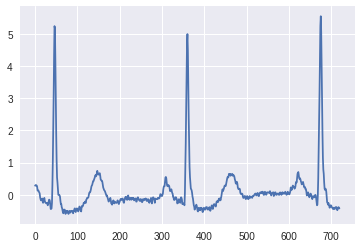

In [0]:
idx_n = np.where(y_train == 0)[0]
plt.plot(X_train[idx_n[0]])

一方でVEBの波形は規則性が乱れ，R波ピークの形状やピーク間距離も正常例とは異なる性質を示していることが分かります．

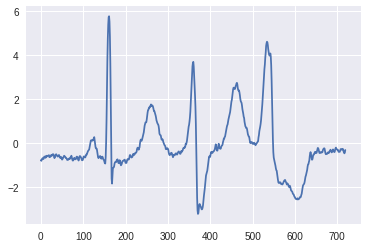

In [0]:
idx_s = np.where(y_train == 1)[0]
plt.plot(X_train[idx_s[0]])

本章の目的は，ECGシグナル特徴をうまく捉え，新たな波形サンプルに対しても高精度に正常/異常を予測するモデルを構築することです．

次節では，深層学習を利用したモデル構築について説明していきます．

## 深層学習を用いた時系列データ解析

### 学習

まず，前節で準備した前処理済みデータをChainerで読み込むためのデータセットクラスを定義します．

In [0]:
class ECGDataset(chainer.dataset.DatasetMixin):

    def __init__(
            self,
            path
    ):
        if os.path.isfile(os.path.join(path, 'X.npy')):
            self.X = np.load(os.path.join(path, 'X.npy'))
        else:
            raise FileNotFoundError("{}/X.npy not found.".format(path))
        if os.path.isfile(os.path.join(path, 'y.npy')):
            self.y = np.load(os.path.join(path, 'y.npy'))
        else:
            raise FileNotFoundError("{}/y.npy not found.".format(path))

    def __len__(self):
        return len(self.X)

    def get_example(self, i):
        return self.X[None, i].astype(np.float32), self.y[i]


続いて，学習（＋予測）に利用するネットワーク構造を定義します．

今回は，画像認識タスクで有名な，CNNベースの**ResNet34**と同様のネットワーク構造を利用します．[[文献5](https://arxiv.org/abs/1512.03385)]

ただし，入力シグナルは1次元配列であることから，ここでは画像解析等で一般的に利用される2D Convolutionではなく，前章の遺伝子解析と同様，1D Convolutionを利用します．

In [0]:
import chainer.functions as F
import chainer.links as L
from chainer import reporter
from chainer import Variable
      
    
class BaseBlock(chainer.Chain):

    def __init__(
            self,
            channels,
            stride=1,
            dilate=1
    ):
        self.stride = stride
        super(BaseBlock, self).__init__()
        with self.init_scope():
            self.c1 = L.ConvolutionND(1, None, channels, 3, stride, dilate, dilate=dilate)
            self.c2 = L.ConvolutionND(1, None, channels, 3, 1, dilate, dilate=dilate)
            if stride > 1:
                self.cd = L.ConvolutionND(1, None, channels, 1, stride, 0)
            self.b1 = L.BatchNormalization(channels)
            self.b2 = L.BatchNormalization(channels)

    def __call__(self, x):
        h = F.relu(self.b1(self.c1(x)))
        if self.stride > 1:
            res = self.cd(x)
        else:
            res = x
        h = res + self.b2(self.c2(h))
        return F.relu(h)


class ResBlock(chainer.Chain):

    def __init__(
            self,
            channels,
            n_block,
            dilate=1
    ):
        self.n_block = n_block
        super(ResBlock, self).__init__()
        with self.init_scope():
            self.b0 = BaseBlock(channels, 2, dilate)
            for i in range(1, n_block):
                bx = BaseBlock(channels, 1, dilate)
                setattr(self, 'b{}'.format(str(i)), bx)

    def __call__(self, x):
        h = self.b0(x)
        for i in range(1, self.n_block):
            h = getattr(self, 'b{}'.format(str(i)))(h)
        return h


class ResNet34(chainer.Chain):

    def __init__(self):
        super(ResNet34, self).__init__()
        with self.init_scope():
            self.conv1 = L.ConvolutionND(1, None, 64, 7, 2, 3)
            self.bn1 = L.BatchNormalization(64)
            self.resblock0 = ResBlock(64, 3)
            self.resblock1 = ResBlock(128, 4)
            self.resblock2 = ResBlock(256, 6)
            self.resblock3 = ResBlock(512, 3)
            self.fc = L.Linear(None, 2)

    def __call__(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.max_pooling_nd(h, 3, 2)
        for i in range(4):
            h = getattr(self, 'resblock{}'.format(str(i)))(h)
        h = F.average(h, axis=2)
        h = self.fc(h)
        return h
      

class Classifier(chainer.Chain):

    def __init__(
            self,
            predictor,
            lossfun=F.softmax_cross_entropy
    ):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
            self.lossfun = lossfun

    def __call__(self, *args):
        assert len(args) >= 2
        x = args[:-1]
        t = args[-1]
        y = self.predictor(*x)

        # loss
        loss = self.lossfun(y, t)
        with chainer.no_backprop_mode():
            # other metrics
            accuracy = F.accuracy(y, t)
        # reporter
        reporter.report({'loss': loss}, self)
        reporter.report({'accuracy': accuracy}, self)

        return loss

    def predict(self, x):
        with chainer.function.no_backprop_mode(), chainer.using_config('train', False):
            x = Variable(self.xp.asarray(x, dtype=self.xp.float32))
            y = self.predictor(x)
            return y
          

学習を実行するための準備として，以下の関数を用意します．

- `create_train_dataset()`：学習用データセットを `ECGDataset` クラスに渡す
- `create_trainer()`：学習に必要な設定を行い，Trainerオブジェクトを作成


In [0]:
from chainer import optimizers
from chainer.optimizer import WeightDecay
from chainer.iterators import MultiprocessIterator
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainer.backends.cuda import get_device_from_id


def create_train_dataset(root_path):
    train_path = os.path.join(root_path, 'preprocessed', 'train')
    train_dataset = ECGDataset(train_path)

    return train_dataset


def create_trainer(
    batchsize, train_dataset, nb_epoch=1,
    device=0, lossfun=F.softmax_cross_entropy
):
    # setup model
    model = ResNet34()
    train_model = Classifier(model, lossfun=lossfun)

    # use Adam optimizer
    optimizer = optimizers.Adam(alpha=0.001)
    optimizer.setup(train_model)
    optimizer.add_hook(WeightDecay(0.0001))

    # setup iterator
    train_iter = MultiprocessIterator(train_dataset, batchsize)

    # define updater
    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    # setup trainer
    stop_trigger = (nb_epoch, 'epoch')
    trainer = training.trainer.Trainer(updater, stop_trigger)
    logging_attributes = [
        'epoch', 'iteration',
        'main/loss', 'main/accuracy'        
    ]
    trainer.extend(
        extensions.LogReport(logging_attributes, trigger=(2000 // batchsize, 'iteration'))
    )
    trainer.extend(
        extensions.PrintReport(logging_attributes)
    )
    trainer.extend(
        extensions.ExponentialShift('alpha', 0.75, optimizer=optimizer),
        trigger=(4000 // batchsize, 'iteration')
    )

    return trainer

これで学習の準備が整ったので，関数を呼び出してtrainerを作成します．

In [0]:
train_dataset = create_train_dataset(dataset_root)

In [0]:
trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0)

それでは学習を開始しましょう. (1分30秒程度で学習が完了します．)

In [0]:
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           1.1307      0.868304       
0           14          0.273237    0.923549       
0           21          0.0950281   0.96596        
0           28          0.058416    0.982701       
0           35          0.0658751   0.982143       
0           42          0.0506687   0.985491       
0           49          0.057125    0.986607       
0           56          0.063658    0.986607       
0           63          0.0600915   0.981027       
0           70          0.0391555   0.988281       
0           77          0.0325103   0.991629       
0           84          0.0344455   0.987723       
0           91          0.0281526   0.989955       
0           98          0.0266191   0.991629       
0           105         0.0318078   0.990513       
0           112         0.0304052   0.991071       
0           119         0.0293185   0.993304       
0           126         0.0290823   0.989397       
0           13

学習が問題なく進めば，main/accuracyが0.99 (99%)付近まで到達していると思います．

### 評価

学習したモデルを評価用データに当てはめて識別性能を確認するため，以下の関数を用意します．

- `create_test_dataset()` : 評価用データの読み込み
- `predict()` : 推論を行い，結果の配列（正解ラベルと予測ラベル）を出力
- `print_confusion_matrix()` : 予測結果から混同行列とよばれる表を出力
- `print_scores()` : 予測結果から予測精度の評価指標を出力

In [0]:
from chainer import cuda
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


def create_test_dataset(root_path):
    test_path = os.path.join(root_path, 'preprocessed', 'test')
    test_dataset = ECGDataset(test_path)
    return test_dataset

  
def predict(trainer, test_dataset, batchsize, device=-1):
    model = trainer.updater.get_optimizer('main').target
    ys = []
    ts = []
    for i in range(len(test_dataset) // batchsize + 1):
        if i == len(test_dataset) // batchsize:
            X, t = zip(*test_dataset[i*batchsize: len(test_dataset)])
        else:
            X, t = zip(*test_dataset[i*batchsize:(i+1)*batchsize])
        X = cuda.to_gpu(np.array(X), device)
        y = model.predict(X)
        y = cuda.to_cpu(y.data.argmax(axis=1))
        ys.append(y)
        ts.append(np.array(t))
    return np.concatenate(ts), np.concatenate(ys)

  
def print_confusion_matrix(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    target_names = ['Normal', 'VEB']
    cmx = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx, index=target_names, columns=target_names)
    plt.figure(figsize = (5,3))
    sn.heatmap(df_cmx, annot=True, annot_kws={"size": 18}, fmt="d", cmap='Blues')
    plt.show()
    

def print_scores(y_true, y_pred):
    target_names = ['Normal', 'VEB']
    print(classification_report(y_true, y_pred, target_names=target_names))
    print("accuracy: ", accuracy_score(y_true, y_pred))


評価用データセットを用意し，

In [0]:
test_dataset = create_test_dataset(dataset_root)

評価用データに対して予測を行います． (17秒程度で予測が完了します)

In [0]:
%time y_true_test, y_pred_test = predict(trainer, test_dataset, 256, 0)

CPU times: user 15.6 s, sys: 2.73 s, total: 18.3 s
Wall time: 18.3 s


それでは予測結果を確認していきましょう．

まずは， **混同行列** とよばれる，予測の分類結果をまとめた表を作成します．行方向（表側）を正解ラベル，列方向（表頭）を予測ラベルとして，各項目では以下の集計値を求めています．

* 左上 : 実際に正常拍動であるサンプルが，正常拍動と予測された数
* 右上 : 実際に正常拍動であるサンプルが，VEBと予測された数
* 左下 : 実際にVEBであるサンプルが，正常と予測された数
* 右下 : 実際にVEBであるサンプルが，VEBと予測された数

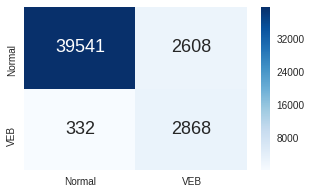

In [0]:
print_confusion_matrix(y_true_test, y_pred_test)

続いて，予測結果から計算される予測精度の評価指標スコアを表示してみましょう．

特に，以下のスコアに注目してみてください．

* 適合率 (Precision) : それぞれの予測診断結果 (Normal or VEB) のうち，正しく診断できていた（正解も同じ診断結果であった）割合
* 再現率 (Recall) : それぞれの正解診断結果 (Normal or VEB) のうち，正しく予測できていた（予測も同じ診断結果であった）割合
* F1値 (F1-score) : 適合率と再現率の調和平均
* 正解率 (Accuracy) : 全ての診断結果 (Normal and VEB) のうち，正しく予測できていた（予測も同じ診断結果であった）割合

In [0]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

      Normal       0.99      0.94      0.96     42149
         VEB       0.52      0.90      0.66      3200

   micro avg       0.94      0.94      0.94     45349
   macro avg       0.76      0.92      0.81     45349
weighted avg       0.96      0.94      0.94     45349

accuracy:  0.9351694634942336


サンプル数が多い正常拍動に対する予測スコアは高い値を示す一方で，サンプル数の少ないVEBに対しては，スコアが低くなる傾向があります．今回のデータセットのように，サンプルが占めるクラスの割合が極端に偏っている不均衡データでは，こうした傾向がしばしば観測されることが知られています．

次節では，このようなクラス不均衡問題への対応をはじめとして，予測モデルを改善するための試行錯誤について幾つか紹介していきます．


## 精度向上に向けて

本節では，前節にて構築した学習器に対して，「データセット」「目的関数」「学習モデル」「前処理」といった様々な観点で工夫を行うことで，精度改善に寄与する方法を模索していきます．

機械学習を用いて解析を行う際には，どの工夫が精度改善に有効なのか予め分からない場合が多く，試行錯誤が必要となります．ただし，手当たり次第の方法を試すことは得策では無いので，対象とするデータセットの性質に基づいて，有効となり得る手段を検討していくことが重要となります．

まずはじめに，前節でも課題として挙がっていた，クラス不均衡の問題への対処法から検討していきましょう．

### クラス不均衡データへの対応

前節でも触れたように，**クラス不均衡データ**を用いて学習器を構築する際，大多数を占めるクラスに偏った予測結果となり，少数のクラスに対して精度が低くなってしまう場合があることが一般的に知られています．一方で，（今回のデータセットを含めて）現実世界のタスクにおいては，大多数の正常サンプルの中に含まれる少数の異常サンプルを精度良く検出することが重要であるというケースは少なくありません．こうした状況において，少数クラスの検出に注目してモデルを学習するための方策が幾つか存在します．

具体的には，

1. **サンプリング**
    - 不均衡データセットからサンプリングを行い，クラス比率のバランスが取れたデータセットを作成．
        - **Undersampling** : 大多数の正常サンプルを削減．
        - **Oversampling**  : 少数の異常サンプルを水増し．
1. **損失関数の重み調整**
    - 正常サンプルを異常と誤分類した際のペナルティを小さく，異常サンプルを正常と誤分類した際のペナルティを大きくする．
    - 例えば，サンプル数の存在比率の逆数を重みとして利用．
1. **目的関数(損失関数)の変更**
    - 異常サンプルに対する予測スコアを向上させるような目的関数を導入．
1. **異常検知**
    - 正常サンプルのデータ分布を仮定し，そこから十分に逸脱したサンプルを異常とみなす．

などの方法があります．本節では，「1.サンプリング」，「3.目的関数の変更」の例を紹介していきます．

#### サンプリング




**Undersampling**と**Oversampling**を組み合わせて，データセットの不均衡を解消することを考えます．

今回は以下のステップでサンプリングを行います．

1. Undersamplingにより，正常拍動サンプルのみ1/4に削減 (VEBサンプルは全て残す)
    * ここでは，単純なランダムサンプリングを採用します．ランダム性があるため，分類にとって重要な（VEBサンプルとの識別境界付近にある）サンプルを削除してしまう可能性があります．
    * ランダムサンプリングの問題を緩和する手法も幾つか存在しますが，今回は使用しません．
1. Oversamplingにより，Undersampling後の正常拍動サンプルと同数になるまでVEBサンプルを水増し
    * SMOTE (Synthetic Minority Over-sampling TEchnique) という手法を採用します．
    * ランダムにデータを水増しする最も単純な方法だと，過学習を引き起こしやすくなります．SMOTEでは，VEBサンプルと，その近傍VEBサンプルとの間のデータ点をランダムに生成してデータに追加していくことで，過学習の影響を緩和しています．

サンプリングを行うために， `SampledECGDataset` クラスを定義します．

また，そのクラスを読み込んで学習用データセットオブジェクトを作成する `create_sampled_train_datset()` 関数を用意します．


In [0]:
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE


class SampledECGDataset(ECGDataset):

    def __init__(
            self,
            path
    ):
        super(SampledECGDataset, self).__init__(path)
        _, counts = np.unique(self.y, return_counts=True)
        self.X, self.y = make_imbalance(
            self.X, self.y,
            sampling_strategy={0: counts[0]//4, 1: counts[1]}
        )
        smote = SMOTE(random_state=42)
        self.X, self.y = smote.fit_sample(self.X, self.y)

        
def create_sampled_train_dataset(root_path):
    train_path = os.path.join(root_path, 'preprocessed', 'train')
    train_dataset = SampledECGDataset(train_path)

    return train_dataset

In [0]:
train_dataset = create_sampled_train_dataset(dataset_root)

それでは先程と同様に，trainerを作成して学習を実行してみましょう．(1分程度で学習が完了します．)

In [0]:
trainer = create_trainer(256, train_dataset, nb_epoch=2, device=0)
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           1.55422     0.71317        
0           14          0.282043    0.902344       
0           21          0.161596    0.939174       
0           28          0.109996    0.960379       
0           35          0.0750687   0.976004       
0           42          0.0759563   0.969866       
0           49          0.0531007   0.979911       
0           56          0.0477525   0.984375       
0           63          0.0657228   0.981585       
0           70          0.0559838   0.979911       
0           77          0.0410638   0.985491       
0           84          0.0311444   0.989397       
1           91          0.0260796   0.993304       
1           98          0.0306111   0.990513       
1           105         0.0267346   0.987165       
1           112         0.0161048   0.995536       
1           119         0.0202833   0.991629       
1           126         0.0112008   0.998326       
1           13

学習が完了したら，評価用データで予測を行い，精度を確認してみましょう．

In [0]:
%time y_true_test, y_pred_test = predict(trainer, test_dataset, 256, 0)

CPU times: user 15.1 s, sys: 2.91 s, total: 18 s
Wall time: 18 s


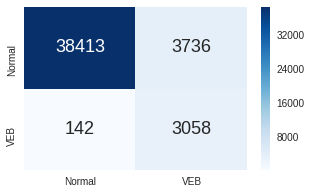

In [0]:
print_confusion_matrix(y_true_test, y_pred_test)

In [0]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

      Normal       1.00      0.91      0.95     42149
         VEB       0.45      0.96      0.61      3200

   micro avg       0.91      0.91      0.91     45349
   macro avg       0.72      0.93      0.78     45349
weighted avg       0.96      0.91      0.93     45349

accuracy:  0.9144854351804891


先程の予測結果と比較して，サンプリングの効果によりVEBサンプルに対する検出精度（特にrecall）が向上しているかを確認してみて下さい．

(サンプリングのランダム性や，学習の初期値依存性などの影響があるため，必ず精度向上するとは限らないことにご注意下さい．)

#### 損失関数の変更

続いて，**損失関数を変更**することで，少数の異常サンプルに対して精度向上させる方法を検討します．少数クラスの予測精度向上に注目した損失関数はこれまでに幾つも提案されていますが，今回はその中で，**Focal loss** という損失関数を利用します．

Focal lossは，画像の物体検知手法の研究論文 [[文献6](https://arxiv.org/abs/1708.02002)] の中で提案された損失関数です．One-stage物体検知手法において，大量の候補領域の中で実際に物体が存在する領域はたかだか数個であることが多く，クラス不均衡なタスクになっており，学習がうまく進まないという問題があります．こうした問題に対処するために提案されたのがfocal lossであり，以下の式によって記述されます．

$$
FL(p_t) = - (1 - p_t)^{\gamma}\log(p_t)
$$

ここで$p_t$はSoftmax関数の出力（確率値）です．$\gamma = 0$の場合，通常のSoftmax cross-entorpy lossと等しくなりますが，$\gamma > 0$の場合，明確に分類可能な（識別が簡単な）サンプルに対して，相対損失を小さくする効果があります．その結果，分類が難しいサンプルにより注目して学習が進んでいくことが期待されます．

下図は，正解クラスの予測確率値と，その際の損失の関係をプロットしており，$\gamma$の値を変化させた場合に，相対損失がどのように下がっていくかを示しています．

![正解予測確率と損失の関係](https://github.com/japan-medical-ai/medical-ai-course-materials/raw/master/notebooks/images/monitoring/focal_plot.png)

([[文献6](https://arxiv.org/abs/1708.02002)]より引用)

それでは実際に，Focal loss関数を定義してみましょう．

In [0]:
from chainer.backends.cuda import get_array_module

def focal_loss(x, t, class_num=2, gamma=0.5, eps=1e-6):
    xp = get_array_module(t)

    p = F.softmax(x)
    p = F.clip(p, x_min=eps, x_max=1-eps)
    log_p = F.log_softmax(x)
    t_onehot = xp.eye(class_num)[t.ravel()]

    loss_sce = -1 * t_onehot * log_p
    loss_focal = F.sum(loss_sce * (1. - p) ** gamma, axis=1)

    return F.mean(loss_focal)

前項目で実施したデータサンプリングは行わず，初期(§8.5)の学習時と同様の設定にした上で，損失関数をfocal lossに変更します．


In [0]:
train_dataset = create_train_dataset(dataset_root)

In [0]:
trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0, lossfun=focal_loss)

それでは学習を開始しましょう．(1分30秒ほどで学習が完了します．)

In [0]:
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           1.21684     0.876674       
0           14          0.149564    0.957589       
0           21          0.0536211   0.976004       
0           28          0.0491485   0.979353       
0           35          0.0278858   0.987165       
0           42          0.0252027   0.989397       
0           49          0.0311808   0.986607       
0           56          0.0199696   0.989955       
0           63          0.0132789   0.99442        
0           70          0.0140394   0.996094       
0           77          0.0144007   0.993304       
0           84          0.0169302   0.992746       
0           91          0.0165225   0.992746       
0           98          0.0110192   0.996094       
0           105         0.0177556   0.992746       
0           112         0.0139628   0.994978       
0           119         0.0113324   0.994978       
0           126         0.010316    0.996094       
0           13

学習が完了したら，評価用データにて予測結果を確認してみましょう．

In [0]:
%time y_true_test, y_pred_test = predict(trainer, test_dataset, 256, 0)

CPU times: user 15.1 s, sys: 2.8 s, total: 17.9 s
Wall time: 17.9 s


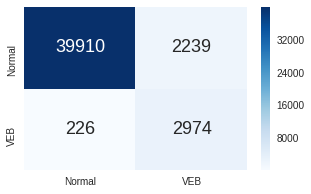

In [0]:
print_confusion_matrix(y_true_test, y_pred_test)

In [0]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97     42149
         VEB       0.57      0.93      0.71      3200

   micro avg       0.95      0.95      0.95     45349
   macro avg       0.78      0.94      0.84     45349
weighted avg       0.96      0.95      0.95     45349

accuracy:  0.9456437848684646


初期モデルの予測結果と，今回の予測結果を比較してみて下さい．

（余力があれば，$\gamma$の値を変化させた場合に，予測結果にどのような影響があるか確認してみて下さい．）

### ネットワーク構造の変更

続いて，学習に用いる**ネットワーク構造を変更**することを検討します．

ここでは，最初に用いたResNet34構造に対して以下の拡張を行います．

1. 1D Convolutionを，**1D Dilated Convolution**に変更
    - Dilated Convolutionを用いることで，パラメータ数の増大を抑えながら，より広範囲の特徴を抽出可能になると期待されます（遺伝子解析の際と同様のモチベーション）．
    - 広範囲の特徴が重要でないタスクの場合には，精度向上に繋がらない（または，場合によっては精度が低下する）可能性もあります．
1. 最終層の手前に全結合層を追加し，**Dropout**を適用
    - Dropoutを行うことで，学習器の汎化性能が向上することを期待します．ただし複数の先行研究([[文献7](https://arxiv.org/abs/1506.02158v6)]など)において，単純に畳み込み層の直後にDropoutを適用するだけでは汎化性能の向上が期待出来ないと報告されていることから，今回は全結合層に適用することにします．

それでは，上記の拡張を加えたネットワークを定義しましょう．（ResBlockクラスは，初期モデル構築時に定義済み）
   

In [0]:
class DilatedResNet34(chainer.Chain):

    def __init__(self):
        super(DilatedResNet34, self).__init__()
        with self.init_scope():
            self.conv1 = L.ConvolutionND(1, None, 64, 7, 2, 3)
            self.bn1 = L.BatchNormalization(64)
            self.resblock0 = ResBlock(64, 3, 1)
            self.resblock1 = ResBlock(128, 4, 1)
            self.resblock2 = ResBlock(256, 6, 2)
            self.resblock3 = ResBlock(512, 3, 4)
            self.fc1 = L.Linear(None, 512)
            self.fc2 = L.Linear(None, 2)

    def __call__(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.max_pooling_nd(h, 3, 2)
        for i in range(4):
            h = getattr(self, 'resblock{}'.format(str(i)))(h)
        h = F.average(h, axis=2)
        h = F.dropout(self.fc1(h), 0.5)
        h = self.fc2(h)
        return h
      

初期(§8.5)の学習時と同様の設定にした上で，ネットワーク構造を `DilatedResNet34` に変更して学習を行います．

In [0]:
def create_trainer(
    batchsize, train_dataset, nb_epoch=1,
    device=0, lossfun=F.softmax_cross_entropy
):
    # setup model
    model = DilatedResNet34()
    train_model = Classifier(model, lossfun=lossfun)

    # use Adam optimizer
    optimizer = optimizers.Adam(alpha=0.001)
    optimizer.setup(train_model)
    optimizer.add_hook(WeightDecay(0.0001))

    # setup iterator
    train_iter = MultiprocessIterator(train_dataset, batchsize)

    # define updater
    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    # setup trainer
    stop_trigger = (nb_epoch, 'epoch')
    trainer = training.trainer.Trainer(updater, stop_trigger)
    logging_attributes = [
        'epoch', 'iteration',
        'main/loss', 'main/accuracy'        
    ]
    trainer.extend(
        extensions.LogReport(logging_attributes, trigger=(2000 // batchsize, 'iteration'))
    )
    trainer.extend(
        extensions.PrintReport(logging_attributes)
    )
    trainer.extend(
        extensions.ExponentialShift('alpha', 0.75, optimizer=optimizer),
        trigger=(4000 // batchsize, 'iteration')
    )

    return trainer

In [0]:
train_dataset = create_train_dataset(dataset_root)
test_dataset = create_test_dataset(dataset_root)

In [0]:
trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0)

それでは，これまでと同様に学習を開始しましょう．(1分30秒ほどで学習が完了します．)

In [0]:
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           1.06941     0.860491       
0           14          0.204161    0.924665       
0           21          0.164622    0.932478       
0           28          0.103986    0.958147       
0           35          0.0782762   0.973772       
0           42          0.0455737   0.988281       
0           49          0.030971    0.989955       
0           56          0.0431471   0.988839       
0           63          0.0427462   0.985491       
0           70          0.0333034   0.991629       
0           77          0.0239444   0.993862       
0           84          0.0325211   0.989397       
0           91          0.0281632   0.991071       
0           98          0.0222488   0.989955       
0           105         0.0232916   0.992746       
0           112         0.0210675   0.992746       
0           119         0.00808897  0.997768       
0           126         0.0198379   0.991629       
0           13

学習が完了したら，評価用データで予測を行い，精度を確認してみましょう．

In [0]:
%time y_true_test, y_pred_test = predict(trainer, test_dataset, 256, 0)

CPU times: user 15.1 s, sys: 2.8 s, total: 17.9 s
Wall time: 17.9 s


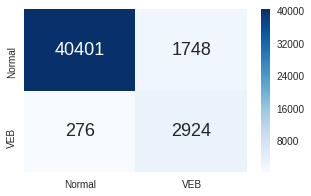

In [0]:
print_confusion_matrix(y_true_test, y_pred_test)

In [0]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

      Normal       0.99      0.96      0.98     42149
         VEB       0.63      0.91      0.74      3200

   micro avg       0.96      0.96      0.96     45349
   macro avg       0.81      0.94      0.86     45349
weighted avg       0.97      0.96      0.96     45349

accuracy:  0.9553683653443296


初期モデルの予測結果と，今回の予測結果を比較してみて下さい．

### ノイズ除去の効果検証

最後に，心電図に含まれる**ノイズの除去**について検討します．

心電図波形には，以下のような外部ノイズが含まれている可能性があります．[[文献8](http://www.iosrjournals.org/iosr-jece/papers/ICETEM/Vol.%201%20Issue%201/ECE%2006-40-44.pdf)]

* 高周波
    * **筋電図ノイズ** (Electromyogram noise)
        - 体動により，筋肉の電気的活動が心電図に混入する場合があります．
    * **電力線誘導障害** (Power line interference)
        - 静電誘導により交流電流が流れ込み，心電図に混入する場合があります．
        - 電源配線に電流が流れることで磁力線が発生し，電磁誘導作用により交流電流が流れ込む場合があります．
    * **加算性白色ガウスノイズ** (Additive white Gaussian noise)
        - 外部環境に由来する様々な要因でホワイトノイズが混入してきます．
* 低周波
    * **基線変動** (Baseline wandering)
        - 電極の装着不良，発汗，体動などの影響で，基線がゆっくり変動する場合があります．

心電図を解析する際は，頻脈や徐脈などの異常波形を正確に判別するために，上記のようなノイズを除去する前処理が行われるのが一般的です．

ノイズを除去する方法は幾つかありますが，最も単純なのは，線形フィルタを適用する方法です．今回は線形フィルタの一つであるバターワースフィルタを用いて，ノイズ除去を試してみましょう．

`BaseECGDatasetPreprocessor` にシグナルノイズ除去の機能を追加した， `DenoiseECGDatasetPreprocessor` クラスを定義します．

In [0]:
from scipy.signal import butter, lfilter


class DenoiseECGDatasetPreprocessor(BaseECGDatasetPreprocessor):

    def __init__(
            self,
            dataset_root='./',
            window_size=720
    ):
        super(DenoiseECGDatasetPreprocessor, self).__init__(
        dataset_root, window_size)

    def _denoise_signal(
            self,
            signal,
            btype='low',
            cutoff_low=0.2,
            cutoff_high=25.,
            order=5
    ):
        nyquist = self.sample_rate / 2.
        if btype == 'band':
            cut_off = (cutoff_low / nyquist, cutoff_high / nyquist)
        elif btype == 'high':
            cut_off = cutoff_low / nyquist
        elif btype == 'low':
            cut_off = cutoff_high / nyquist
        else:
            return signal
        b, a = butter(order, cut_off, analog=False, btype=btype)
        return lfilter(b, a, signal)

    def _segment_data(
            self,
            signal,
            symbols,
            positions
    ):
        X = []
        y = []
        sig_len = len(signal)
        for i in range(len(symbols)):
            start = positions[i] - self.window_size // 2
            end = positions[i] + self.window_size // 2
            if symbols[i] in self.valid_symbols and start >= 0 and end <= sig_len:
                segment = signal[start:end]
                assert len(segment) == self.window_size, "Invalid length"
                X.append(segment)
                y.append(self.labels.index(self.label_map[symbols[i]]))
        return np.array(X), np.array(y)

    def prepare_dataset(
            self,
            denoise=False,
            normalize=True
    ):
        if not os.path.isdir(self.download_dir):
            self.download_data()

        # prepare training dataset
        self._prepare_dataset_core(self.train_record_list, "train", denoise, normalize)
        # prepare test dataset
        self._prepare_dataset_core(self.test_record_list, "test", denoise, normalize)

    def _prepare_dataset_core(
            self,
            record_list,
            mode="train",
            denoise=False,
            normalize=True
    ):
        Xs, ys = [], []
        save_dir = os.path.join(self.dataset_root, 'preprocessed', mode)
        for i in range(len(record_list)):
            signal, symbols, positions = self._load_data(record_list[i])
            if denoise:
                signal = self._denoise_signal(signal)
            if normalize:
                signal = self._normalize_signal(signal)
            X, y = self._segment_data(signal, symbols, positions)
            Xs.append(X)
            ys.append(y)
        os.makedirs(save_dir, exist_ok=True)
        np.save(os.path.join(save_dir, "X.npy"), np.vstack(Xs))
        np.save(os.path.join(save_dir, "y.npy"), np.concatenate(ys))


線形フィルタを適用することで，学習モデルが異常拍動のパターンを特徴として捉えやすくなる可能性があります．一方で，異常拍動を検出するにあたって重要な情報も除去されてしまう可能性があることに注意してください．

また，線形フィルタにおいては，その周波数特性（どの帯域の周波数成分を遮断するか）によって，幾つかの大まかな分類があります．例えば，以下のものがあります．


* **ローパスフィルタ (Low-pass filter)** : 低周波成分のみ通過 (高周波成分を遮断)
* **ハイパスフィルタ (High-pass filter)** : 高周波成分のみ通過 (低周波成分を遮断)
* **バンドパスフィルタ(Band-pass filter)** : 特定の帯域成分のみ通過 (低周波，高周波成分を遮断)

![線形フィルタの周波数特性による分類](https://github.com/japan-medical-ai/medical-ai-course-materials/raw/master/notebooks/images/monitoring/band_form.png)

([[文献9](https://en.wikipedia.org/wiki/Filter_%28signal_processing%29)] より引用)


mitdbでは，予め0.1 Hz 以下の低周波と，100 Hz 以上の高周波をバンドパスフィルタによって除去済みであるため，ここではさらに，25 Hz のローパス・バターワースフィルタによって高周波ノイズを取り除きます．

それでは，ノイズ除去オプションを有効にして，前処理を実行してみましょう．

In [0]:
DenoiseECGDatasetPreprocessor(dataset_root).prepare_dataset(denoise=True)

実際に，高周波ノイズ除去後の波形を可視化してみましょう．

In [0]:
X_train_d = np.load(os.path.join(dataset_root, 'preprocessed', 'train', 'X.npy'))

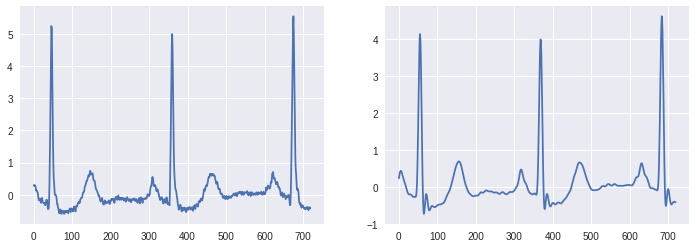

In [0]:
plt.subplots(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(X_train[idx_n[0]])
plt.subplot(1, 2, 2)
plt.plot(X_train_d[idx_n[0]])
plt.show()

左図がフィルタリング前の波形，右図がフィルタリング後の波形です．
細かな振動が取り除かれていることが確認できると思います．

これまでと同様に，ノイズ除去後のデータを用いて学習を行ってみましょう．(1分30秒ほどで学習が完了します．)

In [0]:
train_dataset = create_train_dataset(dataset_root)
test_dataset = create_test_dataset(dataset_root)

In [0]:
trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0)
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           1.21514     0.851562       
0           14          0.283428    0.951451       
0           21          0.157269    0.977679       
0           28          0.141721    0.962612       
0           35          0.0516044   0.986049       
0           42          0.068243    0.987723       
0           49          0.0541831   0.987723       
0           56          0.0363404   0.993304       
0           63          0.0441804   0.992188       
0           70          0.0271119   0.991629       
0           77          0.00849581  0.99721        
0           84          0.0216285   0.996652       
0           91          0.034815    0.990513       
0           98          0.0259185   0.991629       
0           105         0.0240092   0.993862       
0           112         0.00988215  0.99721        
0           119         0.0122308   0.996094       
0           126         0.00706834  0.998326       
0           13

学習が完了したら，評価用データで予測を行い，精度を確認してみましょう．

In [0]:
%time y_true_test, y_pred_test = predict(trainer, test_dataset, 256, 0)

CPU times: user 15.2 s, sys: 2.81 s, total: 18 s
Wall time: 18 s


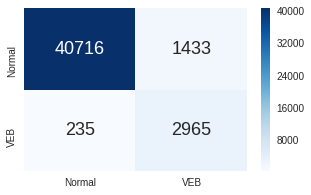

In [0]:
print_confusion_matrix(y_true_test, y_pred_test)

In [0]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98     42149
         VEB       0.67      0.93      0.78      3200

   micro avg       0.96      0.96      0.96     45349
   macro avg       0.83      0.95      0.88     45349
weighted avg       0.97      0.96      0.97     45349

accuracy:  0.9632185935742795


高周波のノイズを除去したことで，予測精度がどのように変わったか確認してみましょう．

## おわりに

本章では，ECGの公開データセットを利用して，不整脈検知の問題に取り組みました．

本講義内容を通じてお伝えしたかったことは，以下となります．

1. 心電図を解析するにあたって必要となる最低限の知識
1. モニタリングデータを解析するための基本的な前処理手順
1. CNNベースのモデルを利用した学習器の構築
1. データセットの性質を考慮した学習方法や前処理の工夫

また，精度向上に向けて様々な手法を試してみましたが，現実世界のタスクにおいては，どの工夫が有効に働くか自明で無い場合がほとんどです．従って，試行錯誤を行いながら，その問題設定に適合するやり方を模索していく必要があります．

さらなる取り組みとしては，例えば下記内容を検討する余地があります．

* 情報の追加
    * $Ⅱ$誘導シグナルに加えて，$V_1$誘導シグナルも同時に入力として与えます．([[文献10](https://www.kdd.org/kdd2018/files/deep-learning-day/DLDay18_paper_16.pdf)]などで実施)
* 前処理の工夫
    * セグメント長の変更
        * より長時間のセグメントを入力とすることで，長期的な波形情報を抽出．([[文献4](https://arxiv.org/abs/1810.04121)]では10秒のセグメントを解析に利用)
        * 入力情報が増えることで，却って学習が難しくなってしまう可能性あり．
    * リサンプリング
        * サンプリング周波数を下げることで，長期的な波形情報を抽出．([[文献4](https://arxiv.org/abs/1810.04121)]では180 Hzにダウンサンプリング)
            * 波形が粗くなることで学習に影響する可能性あり．
            * 適切な前処理を行わないと，折り返し雑音と呼ばれる歪みが発生．
            * （モデルに入力する前に情報を縮小する処理は，画像解析などの分野では一般的）
    * ラベルの追加
        * Normal，VEBに加えて，SVEB（上室異所性拍動）等も追加．
    * ラベルの与え方の変更
        * セグメント範囲内に正常以外のピークラベルが含まれる場合に優先的にそのラベルを付与する，等．
* モデルの変更
    * 長期的な特徴を抽出するために，CNNの後段にRNNベースの構造(LSTMなど)を組み込む ([[文献4](https://arxiv.org/abs/1810.04121)]などで実施)．

余力がある方は，是非チャレンジしてみてください．

また，最近では独自に収集した大規模なモニタリングデータを対象として，研究成果を発表する事例も幾つか出てきています．

* Cardiogram社とカリフォルニア大学の共同研究で，活動量計から心拍数データを収集し，深層学習を用いて糖尿病予備群を予測するDeepHeartを発表[[文献11](https://arxiv.org/abs/1802.02511)]．
* スタンフォード大学のAndrew Ng.の研究室でも，独自に収集したECGレコードから$14$種類の波形クラス分類を予測するモデルを構築し，医師と比較実験を実施[[文献12](https://arxiv.org/abs/1707.01836)]．

デバイスの進歩によって簡単に精緻な情報が収集可能になってきていることから，こうした研究は今後益々盛んになっていくと考えられます．

以上で，モニタリングデータの時系列解析の章は終了となります．お疲れ様でした．

## 参考文献

1. **Electrocardiography** Wikipedia: The Free Encyclopedia. Wikimedia Foundation, Inc. 22 July 2004. Web. 10 Aug. 2004, [[Link](https://en.wikipedia.org/wiki/Electrocardiography)]
1. **心電図健診判定マニュアル**, 日本人間ドック学会, 平成26年4月,  [[Link](https://www.ningen-dock.jp/wp/wp-content/uploads/2013/09/d4bb55fcf01494e251d315b76738ab40.pdf)]
1. **Automatic classification of heartbeats using ECG morphology and heartbeat interval features**, Phillip de Chazal et al., June 2004, [[Link](https://ieeexplore.ieee.org/document/1306572)]
1. **Inter-Patient ECG Classification with Convolutional and Recurrent Neural Networks**, Li Guo et al., Sep 2018, [[Link](https://arxiv.org/abs/1810.04121)]
1. **Deep Residual Learning for Image Recognition**, Kaiming He et al., Dec 2015, [[Link](https://arxiv.org/abs/1512.03385)]
1. **Focal Loss for Dense Object Detection**, Tsung-Yi Lin et al., Aug 2017, [[Link](https://arxiv.org/abs/1708.02002)]
1. **Bayesian Convolutional Neural Networks with Bernoulli Approximate Variational Inference**, Yarin Gal et al., Jun 2015, [[Link](https://arxiv.org/abs/1506.02158v6)]
1. **Noise Analysis and Different Denoising Techniques of ECG Signal - A Survey**, Aswathy Velayudhan et al., ICETEM2016, [[Link](http://www.iosrjournals.org/iosr-jece/papers/ICETEM/Vol.%201%20Issue%201/ECE%2006-40-44.pdf)]
1. **Filter (signal processing)**, Wikipedia: The Free Encyclopedia. Wikimedia Foundation, Inc. 22 July 2004. Web. 10 Aug. 2004, [[Link](https://en.wikipedia.org/wiki/Filter_%28signal_processing%29)]
1. **Arrhythmia Detection from 2-lead ECG using Convolutional Denoising Autoencoders**, Keiichi Ochiai et al., KDD2018, [[Link](https://www.kdd.org/kdd2018/files/deep-learning-day/DLDay18_paper_16.pdf)]
1. **DeepHeart: Semi-Supervised Sequence Learning for Cardiovascular Risk Prediction**, Brandon Ballinger et al., Feb 2018, [[Link](https://arxiv.org/abs/1802.02511)]
1. **Cardiologist-Level Arrhythmia Detection with Convolutional Neural Networks**, Pranav Rajpurkar et al., Jul 2017, [[Link](https://arxiv.org/abs/1707.01836)]